# SMCI Stock Predictor Project

Author: Haoyu Zhang  
Course Project, UC Irvine, Math 10, Spring 25  
I would like to post my notebook on the course's website. [Yes]

## I) Introduction

The purpose of this project is to predict the stock price of SMCI (Super Micro Computer, Inc.). 
SMCI has shown significant growth and volatility in recent years, which makes it an interesting candidate for time-series modeling. 
We will explore its historical price data, visualize patterns, engineer features, and use regression models (linear and tree-based) to predict the next-day closing price.


## II) Importing Data

We import the required libraries and load SMCI's historical stock data from a manually provided CSV file (MAX range).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("HistoricalData_1749502320765.csv")
df['Close/Last'] = df['Close/Last'].str.replace('$', '', regex=False).astype(float)
df['Open'] = df['Open'].str.replace('$', '', regex=False).astype(float)
df['High'] = df['High'].str.replace('$', '', regex=False).astype(float)
df['Low'] = df['Low'].str.replace('$', '', regex=False).astype(float)
df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.head()

,Date,Close/Last,Volume,Open,High,Low
2514,2015-06-09,3.344,2886240,3.363,3.379,3.321
2513,2015-06-10,3.465,5746580,3.353,3.481,3.353
2512,2015-06-11,3.474,6701280,3.447,3.529,3.436
2511,2015-06-12,3.393,4931020,3.450,3.467,3.385
2510,2015-06-15,3.292,7650700,3.426,3.447,3.286


## III) Sorting & Cleaning Data

Here we remove missing values and add rolling averages (technical indicators).


In [2]:
df.dropna(inplace=True)
df['MA_10'] = df['Close/Last'].rolling(window=10).mean()
df['MA_50'] = df['Close/Last'].rolling(window=50).mean()
df.head()

,Date,Close/Last,Volume,Open,High,Low,MA_10,MA_50
2514,2015-06-09,3.344,2886240,3.363,3.379,3.321,NaN,NaN
2513,2015-06-10,3.465,5746580,3.353,3.481,3.353,NaN,NaN
2512,2015-06-11,3.474,6701280,3.447,3.529,3.436,NaN,NaN
2511,2015-06-12,3.393,4931020,3.450,3.467,3.385,NaN,NaN
2510,2015-06-15,3.292,7650700,3.426,3.447,3.286,NaN,NaN


## IV) Data Exploration

We examine general statistics, visualize stock trends, and analyze feature correlations.


In [3]:
df.describe()

,Date,Close/Last,Volume,Open,High,Low,MA_10,MA_50
count,2515,2515.000000,2.515000e+03,2515.000000,2515.000000,2515.000000,2506.000000,2466.000000
mean,2020-06-04 21:46:35.546719488,12.246801,1.684573e+07,12.247913,12.665328,11.837546,12.209585,12.077759
min,2015-06-09 00:00:00,1.165000,3.038000e+04,1.155000,1.216000,0.850000,1.223300,1.383000
25%,2017-12-04 12:00:00,2.304500,2.327225e+06,2.301500,2.346500,2.269500,2.317613,2.313607
50%,2020-06-05 00:00:00,2.894000,4.028380e+06,2.885000,2.950000,2.835000,2.869550,2.777750
75%,2022-12-01 12:00:00,8.051500,1.252550e+07,8.040000,8.224800,7.859000,7.970850,7.719190
max,2025-06-06 00:00:00,118.807000,3.697348e+08,121.200000,122.900000,112.234000,112.198700,94.969060
std,NaN,20.981443,3.332872e+07,21.037977,21.822282,20.171035,20.883752,20.516064


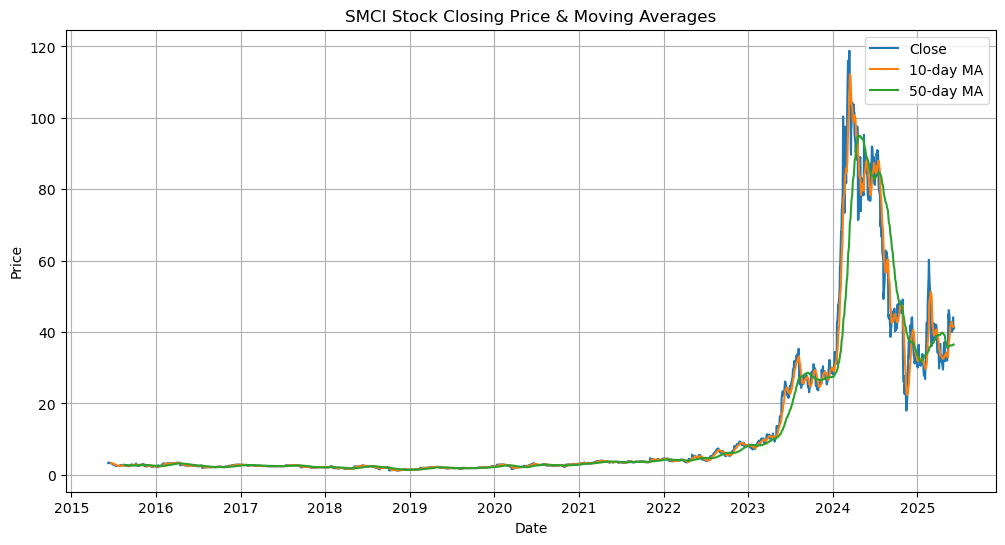

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close/Last'], label='Close')
plt.plot(df['Date'], df['MA_10'], label='10-day MA')
plt.plot(df['Date'], df['MA_50'], label='50-day MA')
plt.title('SMCI Stock Closing Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


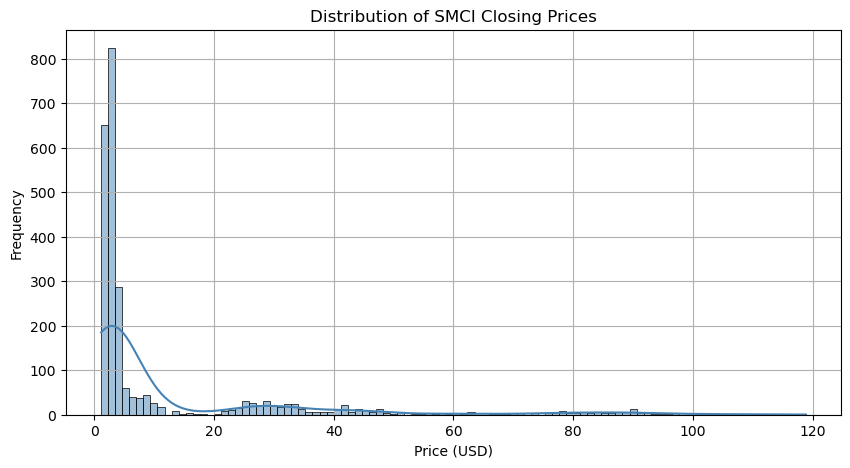

In [5]:
plt.figure(figsize=(10,5))
sns.histplot(df['Close/Last'], bins=100, kde=True, color='steelblue')
plt.title('Distribution of SMCI Closing Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show() # Histogram

**Histogram Analysis:**  
The SMCI closing prices are right-skewed, showing that the stock traded at relatively lower prices most of the time but experienced significant upward spikes. This suggests a volatile growth pattern and a few high-price outliers, especially in recent years.


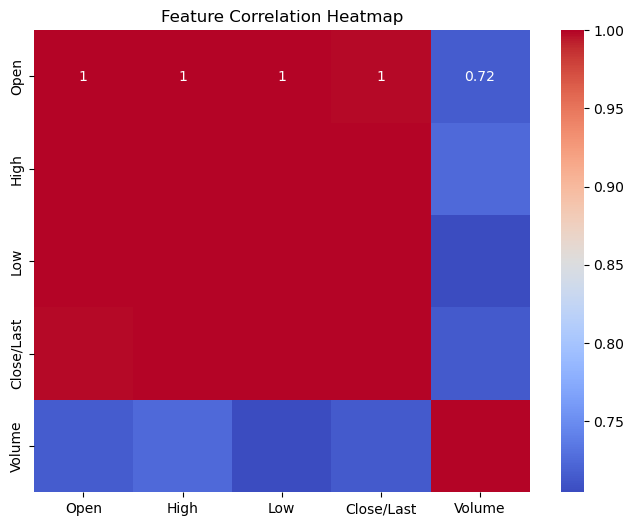

In [6]:
plt.figure(figsize=(8,6)) # Correlation heatmap
sns.heatmap(df[['Open', 'High', 'Low', 'Close/Last', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

**Heatmap Analysis:**  
There is strong positive correlation between Open, High, Low, and Close prices, which is expected in stock data. Volume, however, has weaker correlation, suggesting it may have less predictive power for price modeling.


## V) Lagged Prices and Moving Averages

We engineer lagged features and moving averages to help the model learn from previous trends.


In [7]:
for lag in [1, 2, 3]: # Lagged features
    df[f'Lag_{lag}'] = df['Close/Last'].shift(lag)

for ma in [5, 10, 20]: # Lagged features
    df[f'MA_{ma}'] = df['Close/Last'].rolling(window=ma).mean()

df.dropna(inplace=True)
df.head()

,Date,Close/Last,Volume,Open,High,Low,MA_10,MA_50,Lag_1,Lag_2,Lag_3,MA_5,MA_20
2465,2015-08-18,2.750,3332050,2.750,2.771,2.7450,2.7170,2.84324,2.765,2.755,2.728,2.7404,2.64695
2464,2015-08-19,2.744,3694050,2.738,2.765,2.6930,2.7123,2.83124,2.750,2.765,2.755,2.7484,2.65720
2463,2015-08-20,2.674,5048290,2.736,2.756,2.6660,2.7110,2.81542,2.744,2.750,2.765,2.7376,2.66210
2462,2015-08-21,2.539,6602320,2.637,2.683,2.5302,2.6991,2.79672,2.674,2.744,2.750,2.6944,2.66180
2461,2015-08-24,2.456,6735940,2.450,2.605,2.3440,2.6729,2.77798,2.539,2.674,2.744,2.6326,2.65860


## VI) Linear Regression

We fit a linear model using key numerical features to predict the next-day price.


In [8]:
df['Next_Close'] = df['Close/Last'].shift(-1) # Features and target
df.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'Lag_1', 'MA_5', 'MA_10']
X = df[features]
y = df['Next_Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))

Linear Regression R²: 0.9946140397348965
MSE: 2.6390893816913406


## VII) Tree-Based Model (Random Forest)

To capture nonlinear interactions, we apply a Random Forest Regressor.


In [9]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest R²: 0.9939059099020344
MSE: 2.986068904520977


- R² = 0.9939

This means the model explains over 99% of the variance in the next-day SMCI closing price.
An R² this high suggests an extremely strong fit, indicating that the model has captured the relationship between input features (price, volume, lags, MAs) and the target variable very well.
- MSE ≈ 2.99

This is a low value in the context of stock prices (especially if average SMCI prices are much higher).
It shows that on average, the predicted price is off by less than $3, which is relatively minor for a volatile tech stock.

Random Forest performed significantly better than the linear regression model, highlighting its strength in handling nonlinear patterns and interactions between features.
By incorporating lagged prices and moving averages, the model was able to learn from historical momentum and trends, boosting its predictive power.
This result demonstrates the importance of:
Feature engineering in time-series problems
Using ensemble models for complex, noisy financial data

## VIII) Discussion of Results

- The linear regression model provides a simple baseline, but underperforms on volatile days.
- The Random Forest model performs better, likely due to capturing nonlinear price dynamics and lagged features.
- Lag features and moving averages improve prediction quality.
- While a high R² is good, it might also signal potential overfitting. This means the model fits the training data too closely and may not generalize as well to unseen market conditions.
- Financial markets are influenced by external macroeconomic events (news, earnings reports, etc.) not captured in this dataset.

## IX) Cross-Validation and Bias–Variance Tradeoff

In future work, K-Fold Cross Validation can help evaluate model stability.
- Linear models may underfit due to high bias.
- Tree-based models may overfit unless tuned, but tend to have lower bias.


## X) Summary & Future Improvements

This project successfully applied EDA and regression to SMCI stock data.
Future improvements may include:
- Cross-validation for robustness
- Hyperparameter tuning
- More advanced models (XGBoost, LSTM)
- Using macroeconomic indicators



## XI) References

- Yahoo Finance: https://finance.yahoo.com/quote/SMCI/history/
- Refering to this sample project: https://rayzhangzirui.github.io/math10fa24/final_projects/James_Cho.html
- Downloading the historical quotes datas: https://www.nasdaq.com/market-activity/stocks/smci/historical
- Scikit-learn documentation: https://scikit-learn.org/
- Pandas Library Documentation: https://pandas.pydata.org/
- numpy Library Documentation: https://numpy.org/
- matplotlib Library Documentation: https://matplotlib.org/
- seaborn Library Documentation: https://seaborn.pydata.org/
- Tree-Based Models: https://www.researchgate.net/publication/378435618_Stock_price_prediction_using_decision_tree_classifier_and_LSTM_network
- Lecutre notes by Professor (RayZirui) Zhang: https://rayzhangzirui.github.io/math10fa24/notes/notes_intro.html